# QuisKit Terra in Python 3 (Ubuntu Linux)

https://qiskit.org/terra

In [1]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [3]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, BasicAer, execute

q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(q[0])
qc.cx(q[0], q[1])
qc.measure(q, c)

backend = BasicAer.get_backend('qasm_simulator')
job_sim = execute(qc, backend)
sim_result = job_sim.result()

print(sim_result.get_counts(qc))

/usr/local/lib/python3.6/dist-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


{'11': 496, '00': 528}


In [5]:
res = sim_result.get_counts(qc)
assert res['11'] >= 100 and res['00'] >= 400

In [7]:
sim_result.circuit_statuses()

/usr/local/lib/python3.6/dist-packages/qiskit/result/result.py:288: DeprecationWarning: circuit_statuses() is deprecated and will be removed in version 0.7+. Instead use result.results[x]status directly.
  'directly.', DeprecationWarning)


['DONE']

In [9]:
sim_result.status

'COMPLETED'

In [6]:
import numpy as np
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import BasicAer
from qiskit_aqua.algorithms import AmplitudeEstimation
from qiskit_aqua.algorithms.single_sample.ae.q_factory import QFactory
from qiskit_aqua.components.uncertainty_problems import UncertaintyProblem
from qiskit_aqua.utils.circuit_utils import cry

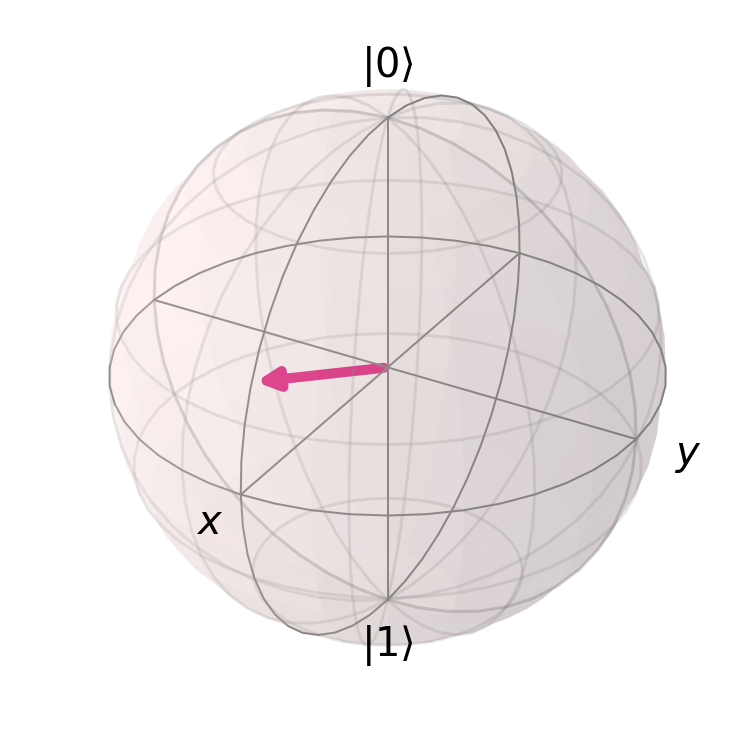

In [7]:
# the probability to be recovered
probability = 0.3
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
plot_bloch_vector([np.sin(theta_p), 0.0, np.cos(theta_p)])

In [8]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """

    def __init__(self, probability=0.5, i_state=None):
        super().__init__(1)
        self._probability = probability
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        if i_state is None:
            i_state = 0
        self._params = {'i_state': i_state}

    def build(self, qc, q, q_ancillas=None, params=None):
        if params is None:
            params = self._params
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[params['i_state']])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """

    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value)

    def build(self, qc, q, q_ancillas=None, params=None):
        i_state = self.a_factory._params['i_state']
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(q[i_state], 2 * theta_p)

    def build_controlled_power(self,
                               qc,
                               q,
                               q_control,
                               power,
                               q_ancillas=None,
                               params=None):
        i_state = self.a_factory._params['i_state']
        theta_p = self.a_factory._theta_p
        cry(2 * power * theta_p, q_control, q[i_state], qc)

In [9]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

In [10]:
# set number of evaluation qubits
m = 3

# construct amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
ae = AmplitudeEstimation(m, bernoulli_a_factory, q_factory=bernoulli_q_factory)

In [11]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'))
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [20]:
all(_ >= 0 for _ in result['values'])

True

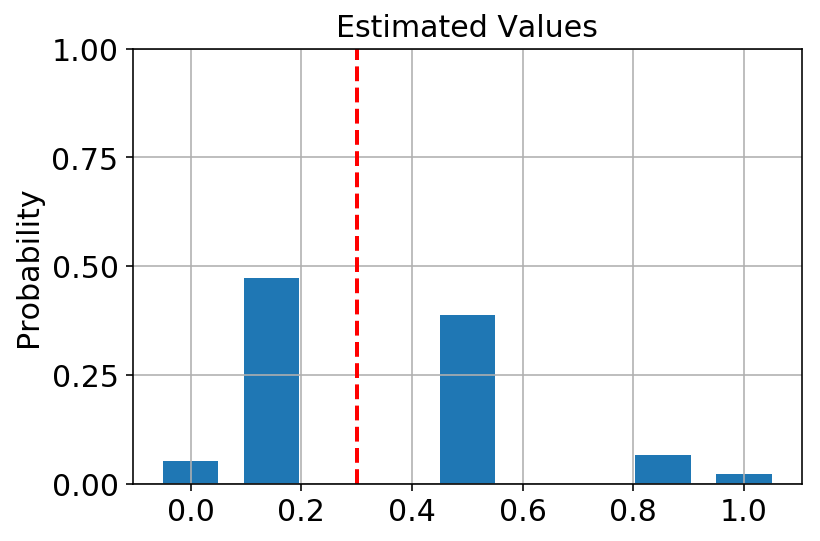

In [13]:
# plot estimated values
import matplotlib.pyplot as plt

plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()